## Initial sRRR exploration on Purkinje cell firing rates and locomotion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

from sparseRRR import elastic_rrr, elastic_rrr_bootstrap, elastic_rrr_cv, dimensionality, bibiplot, plot_cv_results, relaxed_elastic_rrr
from sklearn.exceptions import ConvergenceWarning

In [2]:
def preprocess(data):
    X = data['Firing rate']
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    Y = data['Locomotion']
    Y = Y - np.mean(Y, axis=0)
    Y = Y / np.std(Y, axis=0)
    
    return X,Y

In [3]:
file_names = [
    '../data/purkinje_extended_full.pickle',
    '../data/purkinje_extended_nonlinear.pickle',
    '../data/purkinje_extended_linear.pickle'
]

In [4]:
#data = pickle.load(open('../data/purkinje.pickle', 'rb'))
#data = pickle.load(open('../data/purkinje_extended_full.pickle', 'rb'))
#data = pickle.load(open('../data/purkinje_extended_nonlinear.pickle', 'rb'))
data = pickle.load(open('../data/purkinje_extended_linear.pickle', 'rb'))

X,Y = preprocess(data)
cell_names = data['cell_names']
locomotion_names = data['locomotion_names']

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (1816281, 105) 
Shape of Y: (1816281, 37)


It is a lot of timepoints, so let us play around with reduced data set sizes.

In [5]:
selected_features = [5,6,7,8,9,10,11,12,-8,-7,-6,-5,-4,-3,-2,-1]
np.array(locomotion_names)[selected_features]

array(['X-p FR', 'X-p HR', 'X-p FL', 'X-p HL', 'X-s FR', 'X-s HR',
       'X-s FL', 'X-s HL', 'Z-p FR', 'Z-p HR', 'Z-p FL', 'Z-p HL',
       'Z-s FR', 'Z-s HR', 'Z-s FL', 'Z-s HL'], dtype='<U11')

In [6]:
slice = np.linspace(0, 10000, 10000, dtype=int)
slice

array([    0,     1,     2, ...,  9997,  9998, 10000])

## Linear + non-linear !

In [117]:
w,v = relaxed_elastic_rrr(X[slice,:], Y[slice,:][:,selected_features], rank=2, alpha=.4, l1_ratio=1)

print('\nNeurons selected: {}'.format(np.sum(w[:,0]!=0)))
print(cell_names[w[:,0]!=0])


Neurons selected: 10
[b'MC3808_S7' b'MC3810_S9' b'MC5003_S17' b'MC5003_S21' b'MC5003_S25'
 b'MC5003_S28' b'MC5005_S14' b'MC5005_S6' b'MC6001_S13' b'MC6001_S5']


## Non-linear !

In [129]:
w,v = relaxed_elastic_rrr(X[slice,:], Y[slice,:][:,selected_features], rank=2, alpha=.516, l1_ratio=1)

print('\nNeurons selected: {}'.format(np.sum(w[:,0]!=0)))
print(cell_names[w[:,0]!=0])


Neurons selected: 10
[b'MC5003_S1' b'MC5003_S30' b'MC5003_S8' b'MC5005_S2' b'MC5005_S6'
 b'MC5005_S9' b'MC5006_S2' b'MC6001_S3' b'MC6001_S7' b'MC6002_S2']


## Linear !

In [140]:
w,v = relaxed_elastic_rrr(X[slice,:], Y[slice,:][:,selected_features], rank=2, alpha=.59, l1_ratio=1)

print('\nNeurons selected: {}'.format(np.sum(w[:,0]!=0)))
print(cell_names[w[:,0]!=0])


Neurons selected: 10
[b'MC4017_S10' b'MC4017_S2' b'MC5003_S1' b'MC5003_S21' b'MC5003_S25'
 b'MC5003_S28' b'MC5003_S30' b'MC5005_S14' b'MC5005_S5' b'MC6001_S5']


Notice that here we changed the regularization strength $\alpha$ to select 10 neurons each time.

How well are we predicting, on the training set, different behaviorial variables (locomotion)?

In [52]:
for i in selected_features:
    r2=1-np.sum((Y[slice,i]-(X@w@v.T)[slice,i])**2)/np.sum(Y[slice,i]**2)
    print(locomotion_names[i], ': ', r2)

Wheel Speed :  0.005180145943482817
X-a FR :  0.05511405493490262
X-a HR :  0.05998318480999809
X-a FL :  0.039830657325169105
X-a HL :  0.04059909554326546
X-p FR :  0.7961406096241499
X-p HR :  0.6622788058202784
X-p FL :  0.7412756113698471
X-p HL :  0.596590126565564
X-s FR :  0.46416227375915975
X-s HR :  0.39065652703014997
X-s FL :  0.447727163582769
X-s HL :  0.3411862346049779
Y-a FR :  0.0002810805981682263
Y-a HR :  0.000851162670767236
Y-a FL :  0.00029378290545645225
Y-a HL :  0.00016827213217274206
Y-p FR :  0.013169871281110912
Y-p HR :  0.0015292816964557199
Y-p FL :  0.03463547988763749
Y-p HL :  0.006662247967964552
Y-s FR :  0.010551296275305488
Y-s HR :  0.003271360228707776
Y-s FL :  0.014871696900304432
Y-s HL :  0.011010815281388253
Z-a FR :  0.004595555538981166
Z-a HR :  0.002157507793753788
Z-a FL :  0.004278213315168866
Z-a HL :  0.0002663686073681726
Z-p FR :  0.7134129010943786
Z-p HR :  0.3712087957138789
Z-p FL :  0.6440214129883449
Z-p HL :  0.0390161227

Text(0.5, 1.0, 'Sorted row l2-norms of $W$')

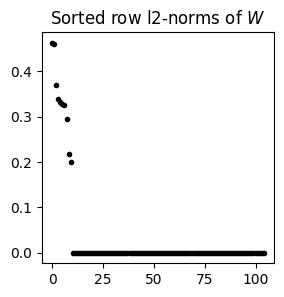

In [101]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(np.sort(np.linalg.norm(w, axis=1))[::-1], '.', color='black')
ax.set_title(r'Sorted row l2-norms of $W$')

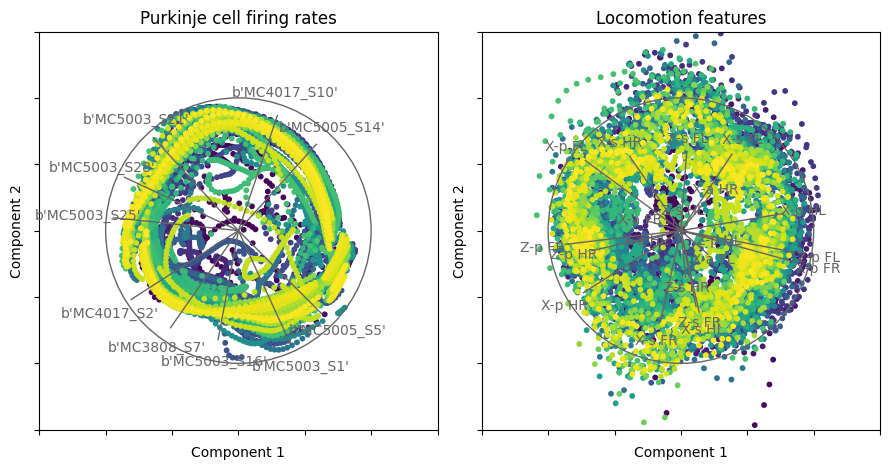

In [105]:
bibiplot(X[slice,:], Y[slice,:][:,selected_features], w, v, 
         titles = ['Purkinje cell firing rates', 'Locomotion features'],
         YdimsNames = np.array(locomotion_names)[selected_features], 
         XdimsNames = cell_names
         )

In [146]:
selected_features = [5,6,7,8,9,10,11,12,-8,-7,-6,-5,-4,-3,-2,-1]
np.array(locomotion_names)[selected_features]

array(['X-p FR', 'X-p HR', 'X-p FL', 'X-p HL', 'X-s FR', 'X-s HR',
       'X-s FL', 'X-s HL', 'Z-p FR', 'Z-p HR', 'Z-p FL', 'Z-p HL',
       'Z-s FR', 'Z-s HR', 'Z-s FL', 'Z-s HL'], dtype='<U11')

In [64]:
slice = np.linspace(0, 10000, 10000, dtype=int)

In [145]:
alphas = np.concatenate((np.arange(.1,1.01,.1), np.arange(2,7)))
l1_ratios = np.array([.25, .5, .75, 1])

cvResults_across_datasets = []

for file in file_names:
    print(file)
    data = pickle.load(open(file, 'rb'))
    X,Y = preprocess(data)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=(ConvergenceWarning, RuntimeWarning))
        cvResults = elastic_rrr_cv(
            X[slice,:],
            Y[slice,:][:,selected_features],
            l1_ratios=l1_ratios,
            alphas=alphas
            )
        cvResults_across_datasets.append(cvResults)

../data/purkinje_extended_full.pickle
1.......... Time: 0.0h  3m 46s
../data/purkinje_extended_nonlinear.pickle
1.......... Time: 0.0h  4m 11s
../data/purkinje_extended_linear.pickle
1.......... Time: 0.0h  4m 36s


../data/purkinje_extended_full.pickle
../data/purkinje_extended_nonlinear.pickle
../data/purkinje_extended_linear.pickle


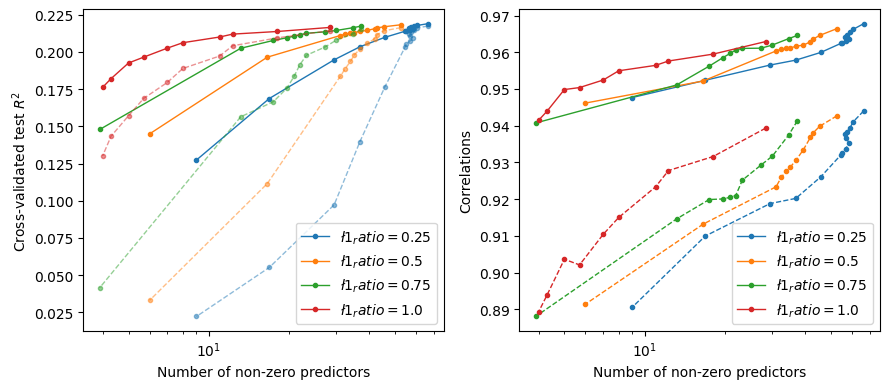

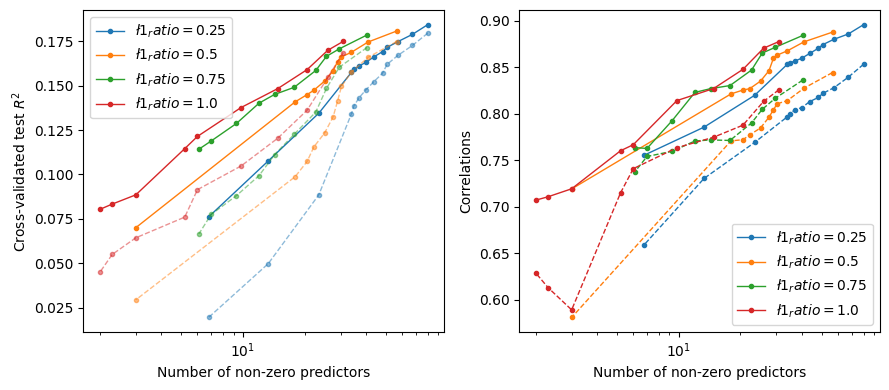

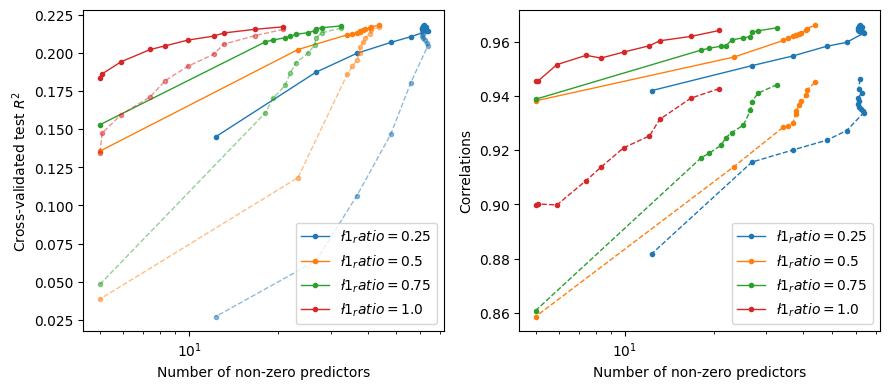

In [ ]:
# This was conducted with all 37 locomotion features
for i, cvResults in enumerate(cvResults_across_datasets):
    print(file_names[i])
    plot_cv_results(*cvResults, l1_ratios)

../data/purkinje_extended_full.pickle
../data/purkinje_extended_nonlinear.pickle
../data/purkinje_extended_linear.pickle


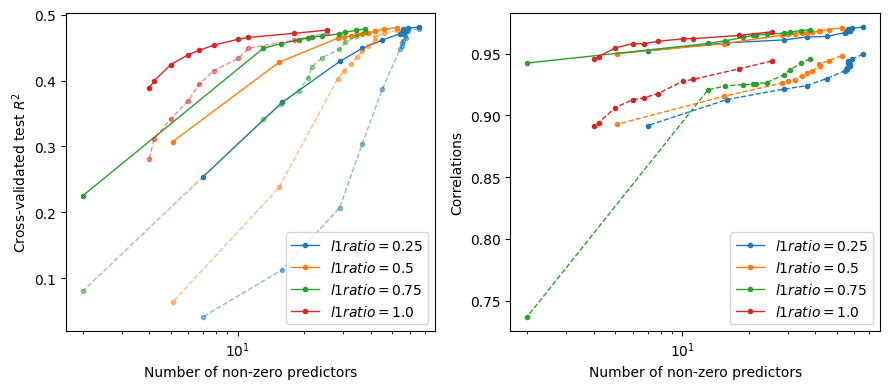

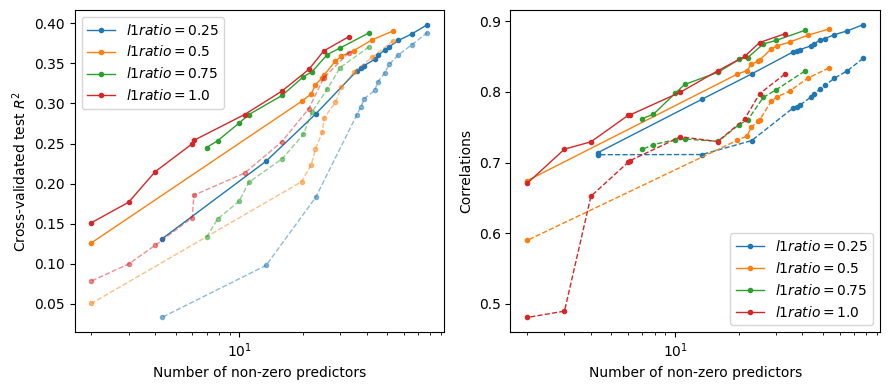

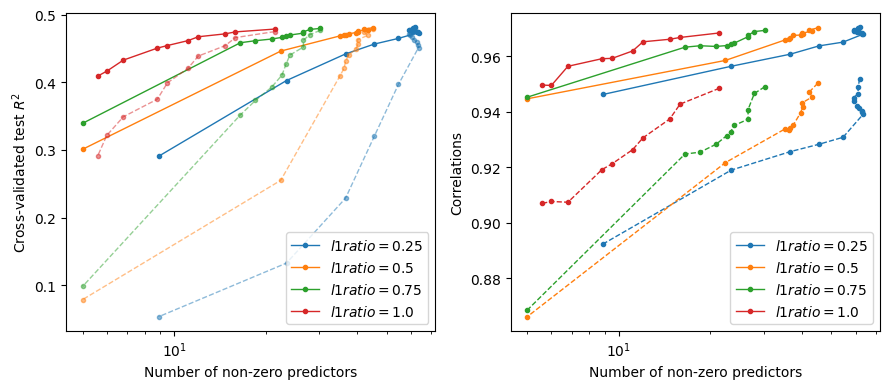

In [147]:
# This was conducted with selected locomotion features
for i, cvResults in enumerate(cvResults_across_datasets):
    print(file_names[i])
    plot_cv_results(*cvResults, l1_ratios)

A strong group lasso penalty in all conditions (linear / nonlinear / linear + nonlinear) seems, in a cross-validated data-driven way, with few (10000 time points) samples, to have the best prediction scores as well as correlations (predicting 37 behaviour variables!). If we do only have the nonlinear term, it will help to introduce many more neurons than say 10. If we do not include it, with just 10 neurons you will already do as best as you can approximately.

In [148]:
neurons_selected = []
#reg_params = [.359, .75, .45] # regularization strength to select 10 neurons/predictors
reg_params = [.4, .516, .59] # regularization strength to select 10 neurons/predictors with selected features
for i, file in enumerate(file_names):
    print('\n', file)
    data = pickle.load(open(file, 'rb'))
    X,Y = preprocess(data)
    cell_names = data['cell_names']
    locomotion_names = data['locomotion_names']

    w,v = relaxed_elastic_rrr(X[slice,:], Y[slice,:][:,selected_features], rank=2, alpha=reg_params[i], l1_ratio=1)

    print('Neurons selected: {}'.format(np.sum(w[:,0]!=0)))
    print(cell_names[w[:,0]!=0])

    neurons_selected.append(np.array(cell_names[w[:,0]!=0]))


 ../data/purkinje_extended_full.pickle
Neurons selected: 10
[b'MC3808_S7' b'MC3810_S9' b'MC5003_S17' b'MC5003_S21' b'MC5003_S25'
 b'MC5003_S28' b'MC5005_S14' b'MC5005_S6' b'MC6001_S13' b'MC6001_S5']

 ../data/purkinje_extended_nonlinear.pickle
Neurons selected: 10
[b'MC5003_S1' b'MC5003_S30' b'MC5003_S8' b'MC5005_S2' b'MC5005_S6'
 b'MC5005_S9' b'MC5006_S2' b'MC6001_S3' b'MC6001_S7' b'MC6002_S2']

 ../data/purkinje_extended_linear.pickle
Neurons selected: 10
[b'MC4017_S10' b'MC4017_S2' b'MC5003_S1' b'MC5003_S21' b'MC5003_S25'
 b'MC5003_S28' b'MC5003_S30' b'MC5005_S14' b'MC5005_S5' b'MC6001_S5']


In [149]:
# same neurons selected in nonlinear + linear vs nonlinear, selected features
np.intersect1d(neurons_selected[0], neurons_selected[1])

array([b'MC5005_S6'], dtype='|S10')

In [150]:
# same neurons selected in nonlinear + linear vs linear, selected features
np.intersect1d(neurons_selected[0], neurons_selected[2])

array([b'MC5003_S21', b'MC5003_S25', b'MC5003_S28', b'MC5005_S14',
       b'MC6001_S5'], dtype='|S10')

In [151]:
# same neurons selected in nonlinear vs just linear, selected features
np.intersect1d(neurons_selected[1], neurons_selected[2])

array([b'MC5003_S1', b'MC5003_S30'], dtype='|S10')

In [12]:
bootCounts = elastic_rrr_bootstrap(X[slice,:], Y[slice,:], alpha=.31, l1_ratio=1)

args = np.argsort(bootCounts)[::-1]
print('')
for i in range(20):
    print('{:10} {:.2f}'.format(cell_names[args[i]], bootCounts[args[i]]))

.................................................................................................... 

b'MC5003_S28' 1.00
b'MC5003_S25' 1.00
b'MC5005_S8' 1.00
b'MC4017_S2' 1.00
b'MC5005_S14' 1.00
b'MC5005_S6' 1.00
b'MC5003_S21' 1.00
b'MC5005_S5' 1.00
b'MC6001_S5' 1.00
b'MC6001_S7' 0.85
b'MC5003_S17' 0.47
b'MC6001_S11' 0.10
b'MC3808_S2' 0.01
b'MC5003_S13' 0.00
b'MC4017_S7' 0.00
b'MC4017_S8' 0.00
b'MC4017_S9' 0.00
b'MC5003_S27' 0.00
b'MC5003_S10' 0.00
b'MC5003_S11' 0.00


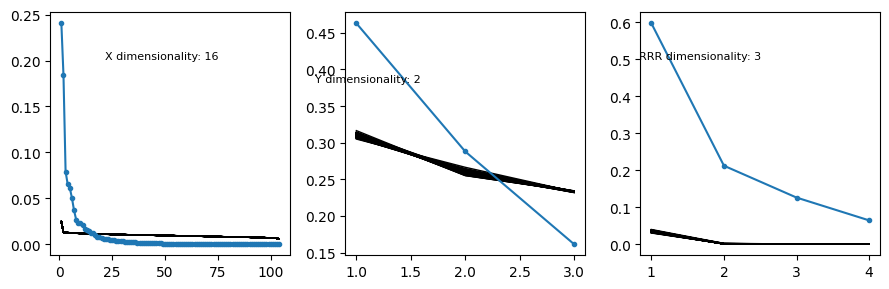

In [29]:
# A quick and dirty way to estimate the dimensionality
dimensionality(X[slice,:], Y[slice,:])